In [ ]:
"""
https://www.analyticsvidhya.com/blog/2020/05/tutorial-real-time-lane-detection-opencv/
여기 사이트 내용을 참고했음.
"""

In [1]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import hallym_utils as hu

In [2]:
"""
각종 경로 설정하기
"""
version = '5'  # 이것만 바꾸면, 경로를 자동으로 설정함

# 이미지 파일로 저장된, 도로 사진 : 입력
dir_path_img_frames_read = 'resource/set1/frames_in/'
if os.path.isdir(dir_path_img_frames_read) == False:
    assert False, '입력용 이미지가 저장된 폴더를 찾을 수 없습니다.'

# 여기 구현된 알고리즘으로 차선 탐지가 된 도로 사진을 저장할 폴더 : 출력
dir_path_img_frames_write = 'resource/set1/frames1_out-v' + version + '/'
if os.path.isdir(dir_path_img_frames_write) == False:
    os.mkdir(dir_path_img_frames_write)  # 디렉토리가 존재하지 않으면 생성
    
print(dir_path_img_frames_write , ' 폴더에 결과물을 저장합니다.')

# 차선 탐지가 된 도로 사진을 동영상으로 만들어서 저장할 결과물
dir_path_video_out = 'resource/set1/'
video_out_filename = 'set1-output-v' + version + '.mp4'
print(video_out_filename, ' 동영상 파일이 생성될 것 입니다.')

# github에 업로드 할 이미지를 저장해 두기 위한 폴더
dir_important_imgs = 'v' + version + '-out-imgs'
if os.path.isdir(dir_important_imgs) == False:
    os.mkdir(dir_important_imgs)  # 폴더가 존재하지 않으면 생성.
    
print(dir_important_imgs, ' 폴더에 샘플 이미지를 저장합니다.')

resource/set1/frames1_out-v5/  폴더에 결과물을 저장합니다.
set1-output-v5.mp4  동영상 파일이 생성될 것 입니다.
v5-out-imgs  폴더에 샘플 이미지를 저장합니다.


In [3]:
"""
주요 파라미터 설정하기
"""

"""
입력으로 들어오는 사진의 크기가, 내가 원하는 크기가 아닐 수 있다. 이를 대비하여 목표로 하는(target) 사진 크기를
미리 정해놓고, 만약 입력으로 들어오는 사진의 크기가 내가 원하는 크기가 아니면 resize 해서 사진 크기를 변경하자
"""
target_height = 270  # 영상의 폭
target_width = 480  # 영상의 높이

half_height = round(target_height / 2)  # 영상의 중심 높이
partial_height = round(target_height / 5) * 3

# height를 기준으로, 어느 높이에서 차선의 중앙을 계산할지, 
# 그리고 사진의 어느 높이에서 내 차의 중앙을 계산할지를 정하는 상수
center_lane_height = round(target_height * 0.7)   
center_myCar_height = round(target_height * 0.95)  # 이것은 사진 바닥에 가까울 수록 좋다.

"""
Frame mask 라는 것을 만들어서, 이미지에 덮어 씌운 다음에 mask 밖의 그림은 다 지워버리고 
mask 내부의 그림만 이용해서 차선을 탐지할 것이다. 이때 frame mask 크기를 얼마로 할 것인지를
설정하기 위해서 frame 왼쪽의 하단, 상단, 그리고 frame 오른쪽의 상단, 하단의 좌표를
아래와 같이 설정하였다.
"""
mask_left_bottom = [0, target_height]
mask_left_top = [220, 160]
mask_right_top = [360, 160]
mask_right_bottom = [target_width, target_height]

# 다항식에 맞춰서 fitting 할때, 몇차 다항식을 쓸건지?
poly_degree = 2
print(str(poly_degree), ' 차 다항식에 fitting 합니다.')

"""
deg-2에 poly fitting 할때, 몇개의 sample을 택할지를 정하기
기본적으로 선의 양 끝을 포함하기 때문에 2개의 점은 기본으로 샘플링 하는거고
그 외에 몇개의 점을 더 샘플링 할지를 정하자
"""
n_samples = 2+5  
print(str(n_samples), ' 개의 샘플을 각 hough line에서 추출합니다')

2  차 다항식에 fitting 합니다.
5  개의 샘플을 각 hough line에서 추출합니다


In [4]:
"""
Read Video Frames
비디오 : https://www.youtube.com/watch?reload=9&v=KWJaBJYJIjI
Frames : 비디오 촬영 영상을 연속된 이미지로 변경 해 놓은 것 (사진파일 다수)

비디오를 직접 입력으로 받지 않고, 비디오를 사진으로 변환한 다음에
사진 파일을 입력으로 받아서 처리한다.
"""

col_frames = os.listdir(dir_path_img_frames_read)
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# load frames
col_images=[]
for i in tqdm_notebook(col_frames):
    img = cv2.imread(dir_path_img_frames_read + i)
    col_images.append(img)


# 이미지를 고정된 크기로 변경
# 입력으로 들어오는 이미지가, 내가 원하는 크기가 아니면, 내가 원하는 크기로 변경
img = col_images[0]
height, width = img.shape[:2]
if (height != target_height) or (width != target_width):
    img = img.resize(img, dsize=(target_width, target_height))

# 읽어온 사진 파일 검증
num_images = len(col_images)
height, width = col_images[0].shape[:2]
print('num images read : ', num_images)
print('image shape : ', height, width)
print('done')

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



num images read :  1108
image shape :  270 480
done


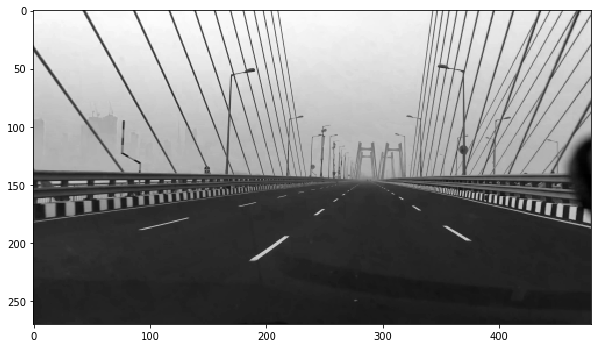

done


In [5]:
# 읽어온 사진 중에서 랜덤으로 하나 골라서 화면에 출력하기

import random
%matplotlib inline

# specify frame index
#idx = random.randint(0, num_images)  # 랜덤으로 이미지 하나 고르기
idx = 1  # 1번 이미지를 선택 : Hough Line Tranf 했을때, 차선 일부만 탐지됨
         # v2, v3 에서 이러한 문제를 개선할 것이므로, 1번 이미지를 예시로 선택

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(col_images[idx][:,:,0], cmap= "gray")
plt.show()

print('done')

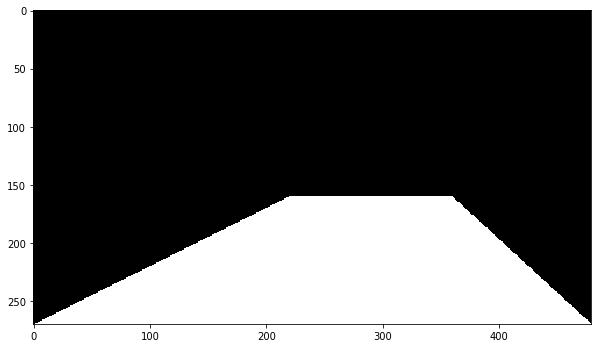

done


In [6]:
"""
Frame Mask Creation : 관심없는 부분은 검은색으로 덮어버리는 부분
즉, 바로 앞에 있는 차선 부분을 제외하고는 모두 검은색으로 덮어서,
차선 탐지가 더 잘 되도록...
=> 차량에 달린 카메라를 통해서 들어오는 영상에 따라서 mask를 약간 조절할 필요가 있을듯.

Our region of interest is in the shape of a polygon. 
We want to mask everything except this region. 
Therefore, we first have to specify the coordinates of the polygon 
and then use it to prepare the frame mask:
"""

# create a zero array
stencil = np.zeros_like(col_images[idx][:,:,0])

# specify coordinates of the polygon
#
# 촬영한 영상에 따라서 다각형의 형태를 조절할 필요가 있겠다.
#
#polygon = np.array([[0,270], [220,160], [360,160], [480,270]])  # v1에서 사용한 값
polygon = np.array([mask_left_bottom, mask_left_top, mask_right_top, mask_right_bottom])  # v1에서 사용한 값

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

# 결과를 화면에 표시 : 아무것도 없는 화면에 다각형의 흰색 + 나머지 검은색 생성
# plot polygon
plt.figure(figsize=(10,10))
plt.imshow(stencil, cmap= "gray")
plt.show()

print('done')

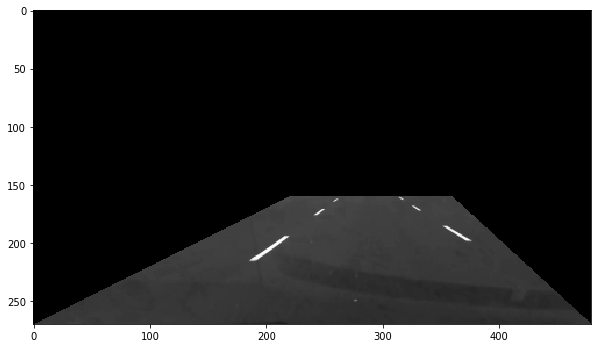

done


In [7]:
# 이렇게 생성한 다각형을, 실제 도로 사진 위에 덮기
# apply polygon as a mask on the frame
img = cv2.bitwise_and(col_images[idx][:,:,0], col_images[idx][:,:,0], mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img, cmap= "gray")
plt.show()

print('done')

In [8]:
"""
다음 작업은 Image pre-processing
e Pre-processing
We have to perform a couple of image pre-processing operations 
on the video frames to detect the desired lane. 
The pre-processing operations are:
1) Image Thresholding
2) Hough Line Transformation
"""

'\n다음 작업은 Image pre-processing\ne Pre-processing\nWe have to perform a couple of image pre-processing operations \non the video frames to detect the desired lane. \nThe pre-processing operations are:\n1) Image Thresholding\n2) Hough Line Transformation\n'

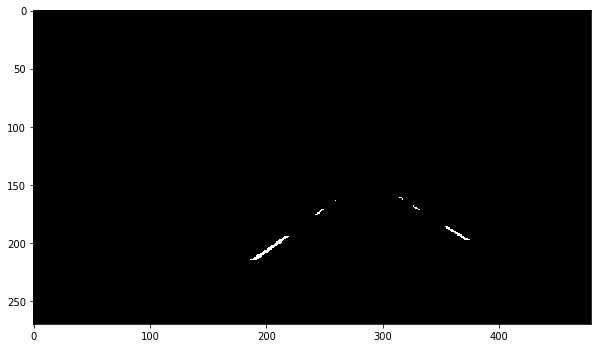

done


In [9]:
"""
1. Image Thresholding
카메라로 획득한 사진을 gray-scale로 변환한 다음에 threshold 기반의 변환 기법을 사용함
즉, [이미지 픽셀값 >= threshold] 이면 한가지 색으로 변환하고
나머지 경우에는 다른 색으로 변환해서, 
이미지를 단순화 하고, 차선 탐지를 쉽게 만들기
"""

# apply image thresholding
ret, thresh = cv2.threshold(img, 130, 145, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

print('done')

** Num lines detected by Hough :  3
slope :  -1.3571428571428572
adding to left
slope :  -1.4
adding to left
slope :  1.5555555555555556
adding to right
fitting... poly
[-4.45912010e-04 -1.24506358e+00  4.75559186e+02]
            2
-0.0004459 x - 1.245 x + 475.6
fitting... poly
[-1.49682592e-16  1.55555556e+00  6.55555556e+01]
            2
-1.497e-16 x + 1.556 x + 65.56


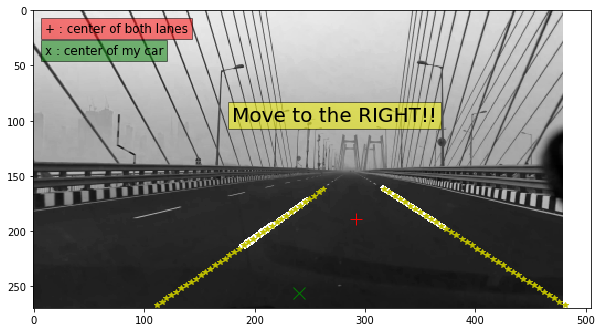

** 참고 **
- 굵은선 : Hough Tranf이 탐지한 차선
- 별표로 그린 선 : poly fit 으로 탐지한 차선
done


In [11]:
"""
2. Hough Line Transformation을 이용한 차선 탐지 
=> Hough + numpy의 polyfit 이용해서 차선탐지

https://pinkwink.kr/1127
https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
"""

# https://m.blog.naver.com/windowsub0406/220894462409
# 흑백으로 변환된 이미지만 입력으로 받을 수 있음
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
print('** Num lines detected by Hough : ', len(lines))

# 원본 사진의 복사본을 만들어랏!
dmy = col_images[idx][:,:,0].copy()

"""
Hough 알고리즘이 탐지한 선을 왼쪽과 오른쪽으로 구분해서 저장.
Hough 알고리즘이 리턴하는 값: 탐지한 선의 한쪽 끝 좌표와 다른쪽 끝 좌표를 각각 (x1,y1), (x2,y2)로 리턴한다.
왼/오른 차선에 해당하는 좌표값들을 저장할 버퍼 공간 생성
"""
left_x, left_y = [], []
right_x, right_y = [], []

"""
만약, 차선을 탐지하지 못하면? 직전에 탐지한 차선을 이어서 사용하자
만약, 과거부터 지금까지 아무런 차선을 탐지하지 못했다면? 차선 탐지를 시작할 때, 
frame mask의 양쪽 끝을 과거에 탐지한 차선이라고 설정하고 시작하자
"""
prev_left_lane = hu.frame_mask_lane(mask_left_bottom, mask_left_top)
prev_right_lane = hu.frame_mask_lane(mask_right_bottom, mask_right_top)

# Hough lines 을 사진위에 덮어서 그리자
for line in lines:
    """ Hough Line 알고리즘으로 선을 탐지한경우, 
        탐지한 선의 한쪽 끝 (x1,y1)과 다른쪽 끝 (x2,y2) 을 알 수 있다. """
    x1, y1, x2, y2 = line[0]
    # 탐지한 선의 경사(=기울기)를 계산한다.
    curr_slope = (x2 - x1) / (y2 - y1)
    print('slope : ', curr_slope)
    if curr_slope < 0 :  # 기울기가 음수이면 왼쪽라인이다! (좌표계 기준이 다름.)
        print('adding to left')
        #left_x.append(x1) left_x.append(x2) left_y.append(y1) left_y.append(y2)
        samples = hu.get_sameples_from_line([x1,y1], [x2,y2], n_samples)
        for sample in samples:
            left_x.append(sample[0])
            left_y.append(sample[1])
    elif curr_slope > 0:  # 기울기가 양수이면 오른쪽라인이다! (좌표계 기준이 다름.)
        print('adding to right')
        #right_x.append(x1) right_x.append(x2) right_y.append(y1) right_y.append(y2)
        samples = hu.get_sameples_from_line([x1,y1], [x2,y2], n_samples)
        for sample in samples:
            right_x.append(sample[0])
            right_y.append(sample[1])
    else:
        assert False, "여기는 절대 도달할 수 없음"  # 경사가 0이 되는 선을 찾는 경우는 없을듯...?
    
    # 먼저, Hough Trasf 이 탐지한 선을 화면에 그림
    cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)  # 사진 복사본 위에, 탐지한 선을 그려넣기

# Hough 로 탐지한 선을 degree-1 poly fitting으로 선을 찾는다.
# 다음으로, 화면 가장 아래에서부터, 어느 정도까지 선을 그리도록 한다.
# 왼쪽 차선을 먼저 그리고, 그 다음으로 오른쪽 차선을 그린다.

y_value_stepsize = 3  # 탐지한 차선을 화면에 그릴때, 얼마나 촘촘하게 그릴 것인지
y_values = np.arange(partial_height, target_height, y_value_stepsize)

# 왼쪽 차선 그리기. x와 y를 일부러 반대로 넣었음.
if len(left_x) > 0: 
    print('fitting... poly')
    left_func = np.polyfit(left_y, left_x, poly_degree)
    
    print(left_func)    
    left_lane = np.poly1d(left_func)
    print(left_lane)
    
    left_xs = left_lane(y_values)
else:
    #assert False, "차선이 탐지되지 않으면?? 가상의 선을 만들어?"
    print('차선이 탐지되지 않아서, 과거에 탐지한 차선을 사용함')
    left_lane = prev_left_lane
    left_xs = left_lane(y_values)
    
# 오른쪽 차선 그리기. x와 y를 일부러 반대로 넣었음.
if len(right_x) > 0:
    print('fitting... poly')
    right_func = np.polyfit(right_y, right_x, poly_degree)
    
    print(right_func)    
    right_lane = np.poly1d(right_func)
    print(right_lane)

    right_xs = right_lane(y_values)
else:
    #assert False, "차선이 탐지되지 않으면?? 가상의 선을 만들어?"    
    print('차선이 탐지되지 않아서, 과거에 탐지한 차선을 사용함')
    right_lane = prev_right_lane
    right_xs = right_lane(y_values)
    

"""
차선이 탐지되지 않으면, Frame masking 할때 사용했던 
다각형의 양쪽 선을 차선으로?

또는, 직전에 사용했던 차선을 계속 사용?
=> 이 경우, 너무 오랫동안 차선이 없으면, 아주 옛날의 차선을
   계속 사용하게 될텐데?
   
TTL (time to live) 같은 값을 둬서,
차선이 탐지 않되면, 직전의 차선을 쓰되, 만약 차선이 탐지되지
않는 기간이 지속되면, 직전에 사용한 차선을 
서서히 Frame Masking 했던 차선으로 옮겨 가면서 사용 하는 것으로 하자.
"""      

"""
height를 기준으로, 어느 높이에서 차선의 중앙을 계산할지, 그리고 내 차의 중앙을 계산할지를 정하는 상수
center_lane_height = round(target_height * 0.8)
center_myCar_height = round(target_heig ht * 0.9)   
"""
# 차선의 중앙을 계산
# - 왼/오른 차선에서, 같은 y 값을 center_lane_height로 대입하면 각각 x 값이 나올텐데, 그 중간이 차선 중간이다.
left_center_x, right_center_x = left_lane(center_lane_height), right_lane(center_lane_height)
center_lane_x = left_center_x + round( (right_center_x - left_center_x) / 2 )

# 내 차의 중간을 계산
# 내 차의 중간은 그림의 x축에서 중앙에 있다고 가정
center_myCar_x = round(target_width / 2)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.plot(left_xs, y_values, 'y*')
plt.plot(right_xs, y_values, 'y*')
plt.plot(center_lane_x, center_lane_height, 'r+', markersize=12)  # 차선의 중앙을 표시
plt.plot(center_myCar_x, center_myCar_height, 'gx', markersize=12)  # 내 차의 중앙을 표시
plt.text(10,20, '+ : center of both lanes', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
plt.text(10,40, 'x : center of my car', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))
if center_lane_x < center_myCar_x:
    msg = 'Move to the LEFT!!'
elif center_lane_x > center_myCar_x:
    msg = 'Move to the RIGHT!!'
else:
    msg = 'I am at the CENTER!!'

plt.text(180,100, msg, fontsize=20, bbox=dict(facecolor='yellow', alpha=0.5))    
    
plt.savefig(dir_important_imgs + '/detection-result.png', dpi=300)  # 그림을 파일로 저장
plt.show()  # 그림을 화면에 출력

print('** 참고 **')
print('- 굵은선 : Hough Tranf이 탐지한 차선')
print('- 별표로 그린 선 : poly fit 으로 탐지한 차선')
print('done')

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  6
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  41
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  66
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  72
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  83
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  147
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  155
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  168
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  181
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  194
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  199
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  207
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  280
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  286
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  353
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  359
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  365
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  371
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  377
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  383
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  415
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  428
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  447

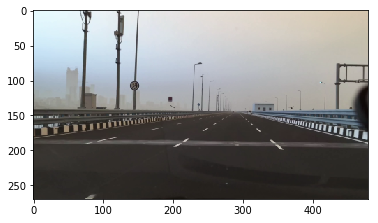

Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1002
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1079
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1080
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1081
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1082
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1083
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1084
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1085
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1086
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1087
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1088
Type Error가 발생했습니다.
Error at INDEX :  1089


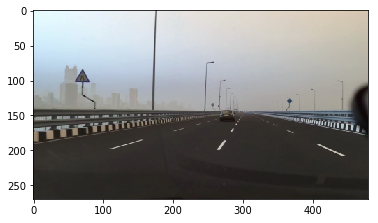

Type Error가 발생했습니다.
Error at INDEX :  1090


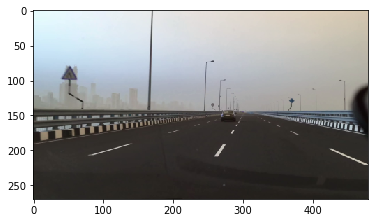

Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1091
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1092
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1093
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1094
Type Error가 발생했습니다.
Error at INDEX :  1095


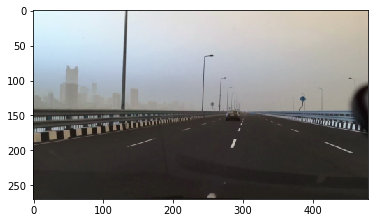

Type Error가 발생했습니다.
Error at INDEX :  1096


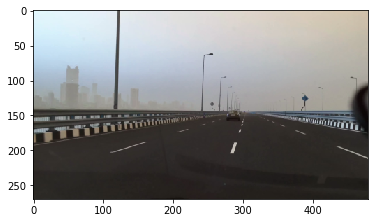

Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1097
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1098
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1099
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1100
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1101
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1102
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1103
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1105
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1106
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1107

done, processed image count :  1108


In [12]:
"""
위의 2개 과정 (threshold => hough transf) 을 모든 사진 프레임에 적용
"""

cnt = 0

y_value_stepsize = 3
y_values = np.arange(partial_height, target_height, y_value_stepsize)

prev_left_lane = hu.frame_mask_lane(mask_left_bottom, mask_left_top)
prev_right_lane = hu.frame_mask_lane(mask_right_bottom, mask_right_top)

for img in tqdm_notebook(col_images):  # 각각의 도로 사진에 대해서...
    masked = cv2.bitwise_and(img[:,:,0], img[:,:,0], mask=stencil)  # frame mask 적용하기
    ret, thresh = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)  # image thresholding 적용하기
    lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
    dmy = img.copy()  # 원본 이미지 복사본 만들어서, 그 위에다가 탐지한 선을 그리기

    # Plot detected lines : 탐지한 선을 그리기!
    left_x, left_y = [], []
    right_x, right_y = [], []
    
    try:
        for line in lines:  # 사진에서 탐지한 모든 Hough line에 대해서...
            x1, y1, x2, y2 = line[0]
            curr_slope = (x2 - x1) / (y2 - y1)  # 탐지한 차선의 경사를 계산하기
            if curr_slope < 0 :  # 기울기가 음수이면 왼쪽차선이다! 좌표계 기준이 다름.
                #left_x.append(x1) left_x.append(x2) left_y.append(y1) left_y.append(y2)
                samples = hu.get_sameples_from_line([x1,y1], [x2,y2], n_samples)
                for sample in samples:
                    left_x.append(sample[0])
                    left_y.append(sample[1])
            elif curr_slope > 0:  # 기울기가 양수이면 오른차선이다! 좌표계 기준이 다름.
                #right_x.append(x1) right_x.append(x2) right_y.append(y1) right_y.append(y2)
                samples = hu.get_sameples_from_line([x1,y1], [x2,y2], n_samples)
                for sample in samples:
                    right_x.append(sample[0])
                    right_y.append(sample[1])
            else:
                assert False
            
            # Hough 결과를 그림에 표시
            cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
  
        #draw_left, draw_right = False, False
    
        # 왼쪽 차선 그리기. x와 y를 일부러 반대로 넣었음.
        if len(left_x) > 0:  # 왼쪽 차선을 Hough 가 탐지했다면...
            left_func = np.polyfit(left_y, left_x, poly_degree)
            left_lane = np.poly1d(left_func)
            left_xs = left_lane(y_values)
            prev_left_lane = left_lane
        else:  # 왼쪽 차선을 Hough 가 탐지 못했어!!!
            print('Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at : ', cnt)
            left_lane = prev_left_lane
            left_xs = left_lane(y_values)
        
        # 오른쪽 차선 그리기. x와 y를 일부러 반대로 넣었음.
        if len(right_x) > 0:  # 왼쪽 차선을 Hough 가 탐지했다면...
            right_func = np.polyfit(right_y, right_x, poly_degree)
            right_lane = np.poly1d(right_func)
            right_xs = right_lane(y_values)
            prev_right_lane = right_lane
        else:  # 왼쪽 차선을 Hough 가 탐지 못했어!!!
            print('Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at : ', cnt)
            right_lane = prev_right_lane
            right_xs = right_lane(y_values)
            
        # plot frame
        curr_fig = plt.figure(figsize=(10,10))
        plt.imshow(dmy, cmap= "gray")
        plt.plot(left_xs, y_values, 'y*')
        plt.plot(right_xs, y_values, 'y*')
            
        # 차선의 중앙을 계산
        left_center_x = left_lane(center_lane_height)
        right_center_x = right_lane(center_lane_height)
        center_lane_x = left_center_x + round( (right_center_x - left_center_x) / 2 )
        # 내 차의 중간을 계산
        center_myCar_x = round(target_width / 2)

        plt.plot(center_lane_x, center_lane_height, 'r+', markersize=12)  # 차선의 중앙을 표시
        plt.text(10,20, '+ : center of both lanes', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        if center_lane_x < center_myCar_x:
            msg = 'Move to the LEFT!!'                
        elif center_lane_x > center_myCar_x:
            msg = 'Move to the RIGHT!!'                
        else:
            msg = 'I am at the CENTER!!'

        plt.text(180,100, msg, fontsize=20, bbox=dict(facecolor='yellow', alpha=0.5))
        
        plt.plot(center_myCar_x, center_myCar_height, 'gx', markersize=12)  # 내 차의 중앙을 표시
        plt.text(10,40, 'x : center of my car', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))    
        plt.savefig(dir_path_img_frames_write+str(cnt)+'.png')  # 사진을 파일로 저장
        plt.close(curr_fig)  # Notebook에 출력하면 너무 많아서.. 출력 금지!
        
    except TypeError: 
        cv2.imwrite(dir_path_img_frames_write+str(cnt)+'.png',img)  # 원본 그림 저장
        """
        오류가 언제, 왜 발생하는지 분석이 안되서, 일단은 그냥 무시하는 것으로...
        """
        print('Type Error가 발생했습니다.')
        print('Error at INDEX : ', cnt)
        plt.imshow(dmy)
        plt.show()        
        #assert False, "Type Error 가 발생했습니다."

    cnt+= 1

print('done, processed image count : ', cnt)

In [13]:
"""
차선 탐지된 이미지를 묶어서 비디오로 만들기 (1/3)
"""

# specify frames per second
fps = 30.0

from os.path import isfile, join

# get file names of the frames
files = [f for f in os.listdir(dir_path_img_frames_write) 
         if isfile(join(dir_path_img_frames_write, f))]
files.sort(key=lambda f: int(re.sub('\D', '', f)))

print('done')

done


In [14]:
# 차선 탐지된 이미지를 묶어서 비디오로 만들기 (2/3)
# Next, we will get all the frames with the detected lane into a list:

frame_list = []

for i in tqdm_notebook(range(len(files))):
    filename = dir_path_img_frames_write + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_list.append(img)
    
print('done')    

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



done


In [15]:
# 차선 탐지된 이미지를 묶어서 비디오로 만들기 (3/3)
# Finally, we can now combine the frames into a video by using the code below:

# write the video
path_out = dir_path_video_out + video_out_filename
out = cv2.VideoWriter(path_out,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_list)):
    # writing to a image array
    out.write(frame_list[i])

out.release()

print('done')

done


In [ ]:
# THE END